In [1]:
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import h5py
import os

from analysis import plot # imoporting analysis module enables import from model folder
from build_input import t_start, on_time, off_time

TRIAL_NAME = "baseline_test_31"
RESULT_PATH = "simulation_results"
TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)

isbaseline = 'baseline' in TRIAL_NAME

### LFP

In [2]:
elec_id = 0
ecp_file = "ecp.h5"

with h5py.File(os.path.join(TRIAL_PATH, ecp_file), 'r') as f:
    ecp = f['ecp']
    lfp = ecp['data'][:, elec_id]
    lfp -= np.mean(lfp)
    t = np.arange(*ecp['time'])
    fs = 1000 / ecp['time'][2] # sampling rate Hz

In [3]:
if isbaseline:
    on_time, off_time = on_time + off_time, 0.0
else:
#     # if any correction needed
#     t_start = 1.0  # sec. Time to start burst input
#     on_time = 0.5  # sec. Burst input duration
#     off_time = 0.5  # sec. Silence duration
    pass

tseg = 0.25
f, pxx, stim_cycle = plot.get_psd_on_stimulus(
    t, lfp, fs, on_time, off_time, t_start, tseg=tseg)

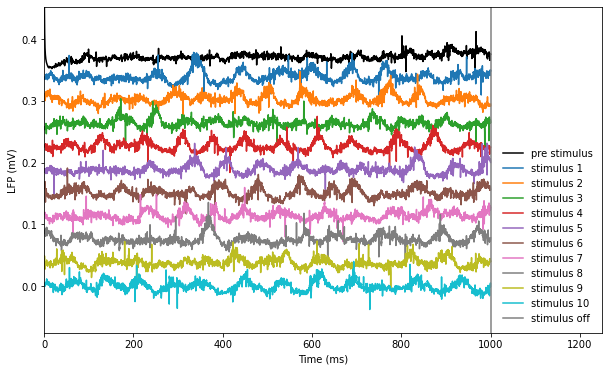

In [4]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))
plot.plot_stimulus_cycles(t, lfp, stim_cycle, dv_n_sigma=5., var_label='LFP (mV)', ax=ax)
plt.show()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 8 - 600 Hz                        
                                 Frequency Resolution is 4.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -5.9756, 1.0973                                          
                                                                                                  
                                       9 peaks were found:                                        
          

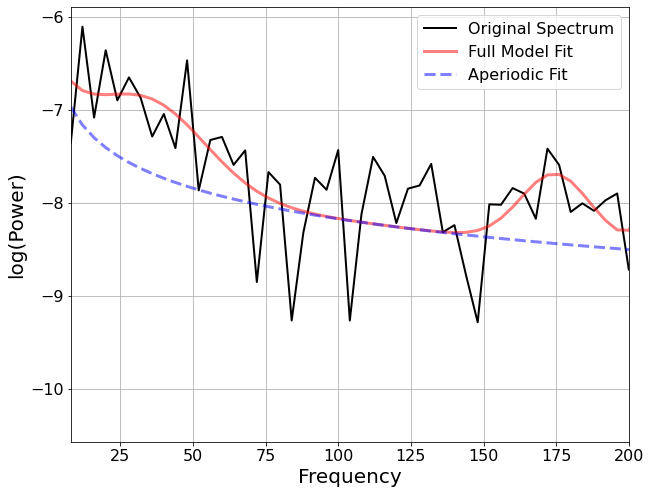

In [5]:
plt_range = 200.
plt_log=False

results, fm = plot.fit_fooof(
    f, pxx, aperiodic_mode='fixed', dB_threshold=3., max_n_peaks=10,
    freq_range=600., peak_width_limits=100, report=True,
    plot=True, plt_log=plt_log, plt_range=plt_range)

save_fooof = False
if save_fooof:
    SAVE_PATH = os.path.join(TRIAL_PATH, 'FOOOF_results')
    fm.save(SAVE_PATH, save_results=True, save_settings=True, save_data=True)

    # Save out a report of the current model fit & results
    REPORT_PATH = os.path.join(TRIAL_PATH, 'FOOOF_report')
    fm.save_report(REPORT_PATH, plt_log=plt_log)

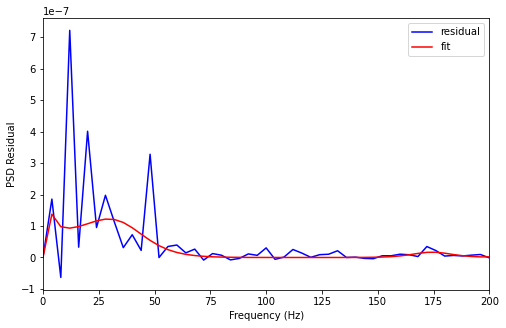

In [6]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
res_psd, res_fit = plot.psd_residual(
    f, pxx, results, plot=True, plt_log=plt_log, plt_range=plt_range, ax=ax)
plt.show()

### Spike rate

In [7]:
# %matplotlib notebook

spike_file = "spike_rate.h5"

with h5py.File(os.path.join(TRIAL_PATH, spike_file), 'r') as f:
    t = np.arange(*f['time'])
    fs = 1000 / f['time'][2] # sampling rate Hz
    pop_rspk = {p: g['data'][()] for p, g in f['populations'].items()}
    pop_num = {p: g.attrs['number'] for p, g in f['populations'].items()}

In [8]:
spike_groups = [['CP', 'CS'], ['FSI'], ['LTS']]
group_label = [' + '.join(spk_grp) for spk_grp in spike_groups]
spike_rate = []
for grp in spike_groups:
    rspk = np.zeros_like(t)
    num = 0
    for p in grp:
        rspk += pop_rspk[p]
        num += pop_num[p]
    rspk *= fs / num
    rspk -= rspk.mean()
    spike_rate.append(rspk)

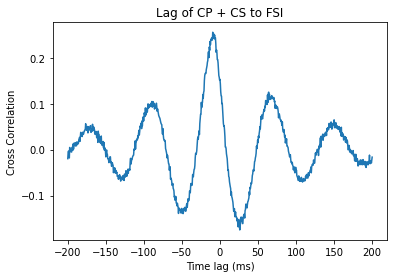

In [9]:
choose_grp = [0, 1]
max_lag = 200. # ms

i_start = int(t_start * fs)
rspk1, rspk2 = spike_rate[choose_grp[0]][i_start:], spike_rate[choose_grp[1]][i_start:]

_, ax = plt.subplots(1, 1)
xcorr, xcorr_lags = plot.xcorr_coeff(rspk1, rspk2, dt=1000 / fs, max_lag=max_lag, ax=ax)
ax.set_xlabel('Time lag (ms)')
ax.set_title('Lag of %s to %s' % (group_label[choose_grp[0]], group_label[choose_grp[1]]))
plt.show()

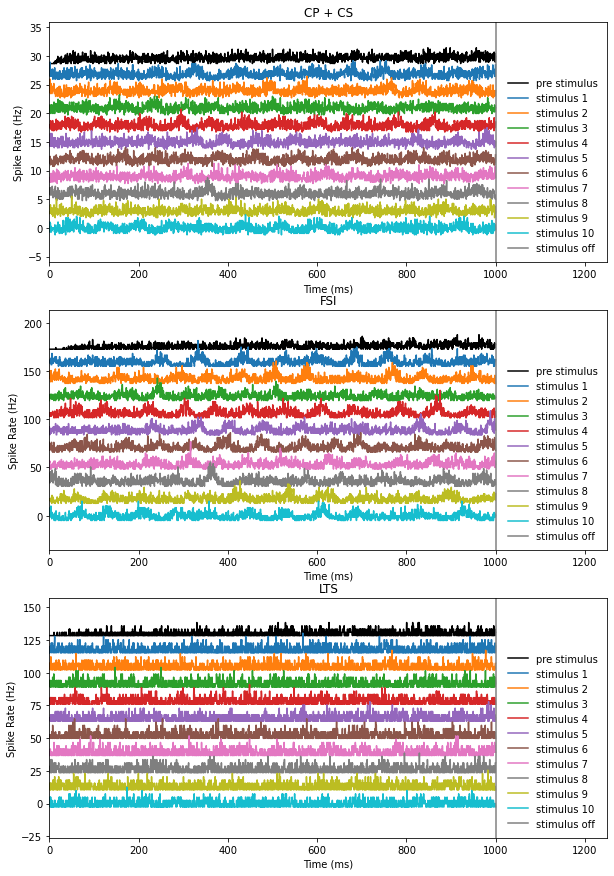

In [10]:
spk_psd = []
_, axs = plt.subplots(3, 1, figsize=(10, 15))
for i, rspk in enumerate(spike_rate):
    f, spk_pxx, stim_cycle = plot.get_psd_on_stimulus(
        t, rspk, fs, on_time, off_time, t_start, tseg=tseg)
    spk_psd.append(spk_pxx)
    plot.plot_stimulus_cycles(t, rspk, stim_cycle, dv_n_sigma=5., var_label='Spike Rate (Hz)', ax=axs[i])
    axs[i].set_title(group_label[i])
plt.show()

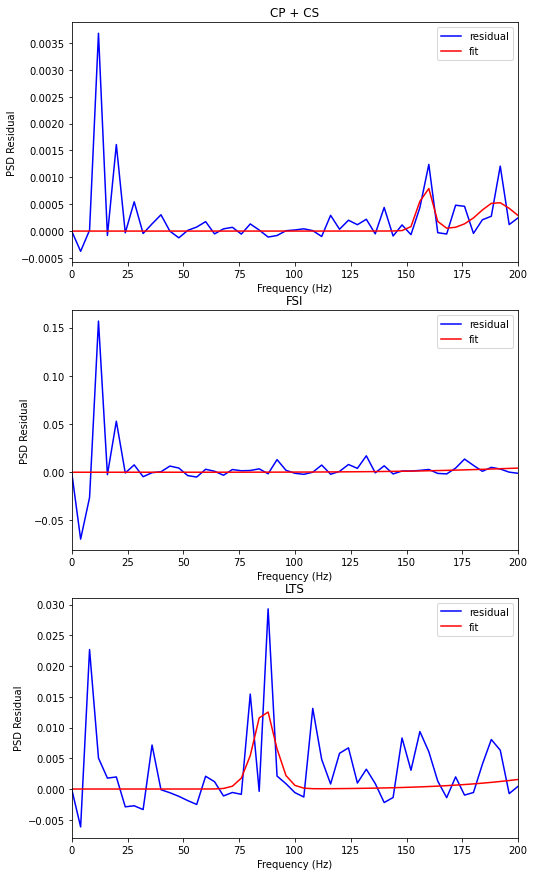

In [11]:
_, axs = plt.subplots(3, 1, figsize=(8, 15))
for i, spk_pxx in enumerate(spk_psd):
    spk_results, fm = plot.fit_fooof(
        f, spk_pxx, aperiodic_mode='fixed', dB_threshold=3., max_n_peaks=10,
        freq_range=600., peak_width_limits=100, report=False, plot=False)
    res_psd, res_fit = plot.psd_residual(
        f, spk_pxx, spk_results, plot=True, plt_log=plt_log, plt_range=plt_range, ax=axs[i])
    axs[i].set_title(group_label[i])
plt.show()